In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import sys
import gc
sys.path.append("..")

from utils import data_loader,utils
import argparse
import random
import pickle as pkl
from tqdm import tqdm
import datetime
from time import time
from algo import GraphHINGE_FFT,GraphHINGE_Conv,GraphHINGE_Cross,GraphHINGE_CrossConv,GraphHINGE_ALL, GraphHINGE_ConvALL
from tensorboardX import SummaryWriter
import numpy as np


Using backend: pytorch


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题


# read drug & disease dict

In [3]:
drugs = []
diseases = []
with open("../data/DDdataset-Raw/drug_dict") as f:
    for line in f:
        drugs.append(line.strip())
with open("../data/DDdataset-Raw/disease_dict") as f:
    for line in f:
        diseases.append(line.strip())
        
drug2disease = {}
disease2drug = {}
with open("../data/DDdataset/drugDisease.txt") as f:
    for line in f:
        drug, disease = line.strip().split('\t')
        drug, disease = int(drug), int(disease)
        drug2disease.setdefault(drug, set())
        drug2disease[drug].add(disease)
        disease2drug.setdefault(disease, set())
        disease2drug[disease].add(drug)
        

# read infer result

In [4]:
from collections import namedtuple
UI = namedtuple("UI", ['user', 'item', 'prob'])


In [5]:
predicts = []
with open("../out/inference/2021-06-03_09-40-07.csv") as f:
    for line in f:
        user, item, prob = line.strip().split('\t')
        ui = UI(int(user)-1, int(item) -1, float(prob))
        predicts.append(ui)
predicts = sorted(predicts, key = lambda ui : ui.prob, reverse = True)

In [6]:
min_u, min_i = 9999, 9999
max_u, max_i = 0, 0
for ui in predicts:
    u = ui.user
    min_u = min(min_u, u)
    max_u = max(max_u, u)
    i = ui.item
    min_i = min(min_i, i)
    max_i = max(max_i, i)
min_u, max_u, min_i, max_i

(0, 1228, 0, 1518)

In [7]:
assert len(diseases) -1 == max_u
assert len(drugs) - 1 == max_i

## print predict

In [62]:
predicts[0]

UI(user=877, item=1330, prob=0.9999949932098389)

In [63]:
cnt = 0
for ui in predicts:    
#     if ui.prob < 0.999:
#         break
#     if ui.user != 962:
#         continue
    print(diseases[ui.user], drugs[ui.item], f"{ui.prob}", sep = '\t')
    print(ui)
    cnt +=1
    break
cnt

C1318973:Staphylococcus aureus infection	DB01327:Cefazolin	0.9999949932098389
UI(user=877, item=1330, prob=0.9999949932098389)


1

# model init

In [9]:
parser = argparse.ArgumentParser(description='Parameters.')
parser.add_argument('-cuda', type=str, default='cpu' ,help='Cuda number.')
parser.add_argument('-hidden', type=int, default=128, help='Hidden Units.')
parser.add_argument('-heads', type=int, default=3, help='Attention heads.')
parser.add_argument('-lr', type=float, default=0.001, help='Learning rate.')
parser.add_argument('-wd', type=float, default=0.0009, help='Weight decay.')
parser.add_argument('-epochs', type=int, default=500,help='Maximum Epoch.')

parser.add_argument('-model', type=str, default='GraphHINGE_FFT',help='Model.')
parser.add_argument('-save_dir', type=str, default='../out',help='Trained models to be saved.')
parser.add_argument('-pretrained', type=str, default='pretrained.pth',help='Load a model from breakpoint.')

parser.add_argument('-d', type=str,help='Dataset.')
parser.add_argument('-p', type=str,help='Dataset path.')
parser.add_argument('-o', type=str,default='../data/data_out',help='Output path.')
parser.add_argument('-b', type=int, default=128, help='Batch size.')
parser.add_argument('-s', type=int,default=0, help='Sample path to be saved.')
parser.add_argument('-n', type=int, default=16,help='Num of walks per node.')
parser.add_argument('-w', type=int, default=1,help='Scale of walk length.')
parser.add_argument('-temp1', type=float, default=0.2, help='Temperature factor for node att.')
parser.add_argument('-temp2', type=float, default=0.2, help='Temperature factor for path att.')
parser.add_argument('-ratio', type=float, default=1, help='Sample ratio.')
parser.add_argument('-train', action= "store_true", default= False,help='If false, model will be loaded from the latest saved one.')
parser.add_argument('-usersid', type=int, action="append", default=None, help='Specify users id to inference. Default all users.')
parser.add_argument('-itemsid', type=int, action="append", default=None, help='Specify items id to inference. Default all items.')
parser.add_argument('-inference', action= "store_true", default=False,help='Inference stage. (Train All data and inference new links between users and items)')
parser.add_argument('-model_state_file', type=str,default = None, help='Load model state file to infer')
parser.add_argument('-use_tensorboard', action= "store_true",default = False)

_StoreTrueAction(option_strings=['-use_tensorboard'], dest='use_tensorboard', nargs=0, const=True, default=False, type=None, choices=None, help=None, metavar=None)

In [10]:
args = [
                "-d", "movielens"
                ,"-p","../data/Movielens"
#                 ,"-cuda", "cpu"#"cuda:0"
                ,"-cuda", "cuda:0"
                ,"-epochs","300"
                ,"-b","1"
                ,"-model_state_file", "NotFFTGraphHINGE_FFT_movielens_train_lr_0.001_bs_128_wd_0.0009.pth"
            ]
args = parser.parse_args(args=args)

In [11]:
args = [
                "-d", "drug"
                ,"-p","../data/DDdataset"
                ,"-cuda","cpu"#"cuda:0"
                ,"-epochs","70"
                ,"-b","1"
                ,"-train"
                ,"-n", "13"
                ,"-inference"
                ,"-model_state_file", "NotFFTGraphHINGE_FFT_drug_inference_Nofold_lr_0.001_bs_128_wd_0.0009.pth"
            ]
args = parser.parse_args(args=args)
args.o += "_inference" if args.inference else ""

In [12]:
usersid = [877]
itemsid = [1330]

In [13]:
i = 0
for user_metas, item_metas, train_loader, eval_loader, test_loader, user_num, item_num, attr1_num, attr2_num, attr3_num in \
    data_loader.Dataloader(args.p, args.d, args.o, args.s, args.n, args.w, args.b, args.inference,ratio=args.ratio,
                           usersid = usersid,
                           itemsid = itemsid).load_data():
        print(i)
        i += 1
device = torch.device(args.cuda)

Graph Loaded.
Train, Inference loaded.
Load paths from:
DrugRepurpose_user_13_1.pkl
DrugRepurpose_item_13_1.pkl
0


In [14]:
if args.model == 'GraphHINGE_FFT':
    model = GraphHINGE_FFT.GraphHINGE(
        user_num, item_num, attr1_num, attr2_num, attr3_num, args.hidden, args.hidden, args.hidden, args.heads, args.temp1, args.temp2, output_attentions= True
        ).to(device)
elif args.model == 'GraphHINGE_Conv':
    model = GraphHINGE_Conv.GraphHINGE(
        user_num, item_num, attr1_num, attr2_num, attr3_num, args.hidden, args.hidden, args.hidden, args.heads, args.temp1, args.temp2
        ).to(device)
elif args.model == 'GraphHINGE_Cross':
    model = GraphHINGE_Cross.GraphHINGE(
        user_num, item_num, attr1_num, attr2_num, attr3_num, args.hidden, args.hidden, args.hidden, args.heads, args.temp1, args.temp2
        ).to(device)
elif args.model == 'GraphHINGE_CrossConv':
    model = GraphHINGE_CrossConv.GraphHINGE(
        user_num, item_num, attr1_num, attr2_num, attr3_num, args.hidden, args.hidden, args.hidden, args.heads, args.temp1, args.temp2
        ).to(device)
elif args.model == 'GraphHINGE_ALL':
    model = GraphHINGE_ALL.GraphHINGE(
        user_num, item_num, attr1_num, attr2_num, attr3_num, args.hidden, args.hidden, args.hidden, args.heads, args.temp1, args.temp2
        ).to(device)
elif args.model == 'GraphHINGE_ConvALL':
    model = GraphHINGE_ConvALL.GraphHINGE(
        user_num, item_num, attr1_num, attr2_num, attr3_num, args.hidden, args.hidden, args.hidden, args.heads, args.temp1, args.temp2
        ).to(device)
else:
    raise NotImplementedError

In [15]:
model_name = '_'.join([args.model, 
        args.d, ("inference" if args.inference else "train"),
        "lr_"+str(args.lr), "bs_"+str(args.b), "wd_"+str(args.wd)]) + '.pth' \
    if args.model_state_file is None \
    else args.model_state_file 
model.load_state_dict(torch.load(os.path.join(args.save_dir, model_name), map_location = device))

<All keys matched successfully>

## infer

In [16]:
def infer(model, device, test_loader, writer, inference_output = None):
    test_loss = []
    test_logloss = []
    pred_list = None
    label_list = None
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader)):
            UI, IU, UIUI, IUIU, UIAI1, IAIU1, UIAI2, IAIU2, UIAI3, IAIU3, labels = data
            users = UI.detach().cpu().numpy()[:, 0, 0]
            items = IU.detach().cpu().numpy()[:, 0, 0]
            user = users[0]
            item = items[0]
            print(user, item)
            pred, attentions = model(UI.to(device), IU.to(device),\
            UIUI.to(device), IUIU.to(device), \
            UIAI1.to(device), IAIU1.to(device), \
            UIAI2.to(device), IAIU2.to(device), \
            UIAI3.to(device), IAIU3.to(device))
            max_path_idx = torch.argmax(attentions['path'][0])
            if max_path_idx < 13:
                continue
  
            pred = pred.detach().cpu().numpy()
            labels = labels.numpy()

            if pred_list is None:
                pred_list = pred
                label_list = labels
            else:
                pred_list = np.vstack([pred_list, pred])
                label_list = np.vstack([label_list, labels])
            if inference_output is not None:
                for user, item, logit, label in zip(users, items, pred, labels):
                    print(user, item, logit[0].item(), sep = '\t', file = inference_output)
                    print(user, item, logit[0].item(), sep = '\t')
                    if logit[0].item() > 0.70:
                        return data, attentions

In [17]:
with open(os.path.join(args.save_dir, "inference", f"jupyter_test.csv"), 'w') as infer_out:
    data, attention = infer(model, device, test_loader, None, infer_out)

  0%|          | 0/1 [00:00<?, ?it/s]

878 1331
878	1331	0.9999949932098389


In [18]:
UI, IU, UIUI, IUIU, UIAI1, IAIU1, UIAI2, IAIU2, UIAI3, IAIU3, labels = data
path = [UI, IU, UIUI, IUIU, UIAI1, IAIU1, UIAI2, IAIU2, UIAI3, IAIU3]

In [19]:
path = [metapath.squeeze() for metapath in path]

In [20]:
UI, IU, UIUI, IUIU, UIAI1, IAIU1, UIAI2, IAIU2, UIAI3, IAIU3 = path

In [21]:
u_path = [metapath for i, metapath in enumerate(path) if i % 2 == 0]
i_path = [metapath for i, metapath in enumerate(path) if i % 2 == 1]
y_labels = ['UI', 'UIUI', 'UIAI1', 'UIAI2', 'UIAI3']
y_labels = ['Metapath 1', 'Metapath 2', 'Metapath 3', 'Metapath 4', 'Metapath 5']
# y_labels = ['UIxIU', 'UIUIxIUIU', 'UIAI1xIAIU1', 'UIAI2xIAIU2', 'UIAI3xIAIU3']

In [22]:
def pad_path_matrix(path_):
    maxLen = 0
    for metapath in path_:
        maxLen = max(metapath.shape[1], maxLen)
    for idx in range(len(path_)):
        metapath = path_[idx]
        lenDif = maxLen - metapath.shape[1]
        if lenDif > 0:
            to_cat = torch.zeros((metapath.shape[0], lenDif), dtype = torch.int64)
            path_[idx] = torch.cat([metapath, to_cat], dim = 1)
    return torch.cat(path_) # 13*5, 4

In [23]:
u_path = pad_path_matrix(u_path)
i_path = pad_path_matrix(i_path)

# attention plot

## path attention 

In [24]:
UI[0][0].item()-1,  IU[0][0].item()-1

(877, 1330)

In [25]:
diseases[UI[0][0].item()-1], drugs[IU[0][0].item()-1]

('C1318973:Staphylococcus aureus infection', 'DB01327:Cefazolin')

In [26]:
cmap = 'gist_gray_r'
path_per_meta = 13

In [27]:
attention['path'][0].reshape(5,-1).to('cpu').sum(dim = 1).reshape(-1).shape

torch.Size([5])

In [28]:
firstBatchPathAttention = attention['path'][0].reshape(5,-1).to('cpu')

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


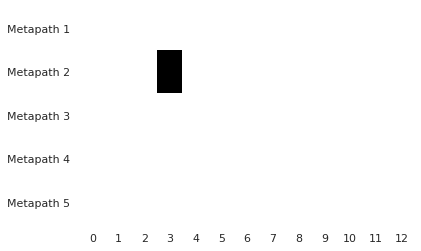

In [29]:
ax = sns.heatmap(firstBatchPathAttention,
                 cmap = cmap,
                 annot=False,
                 fmt = ".1f",
                 yticklabels = y_labels,
                 cbar = False
                )

In [30]:
max_path_idx = torch.argmax(attention['path'][0])
print(u_path[max_path_idx] - 1, i_path[max_path_idx] - 1, max_path_idx)
print("-"*30)
for i, idx in enumerate(u_path[max_path_idx] - 1):
    if i % 2 == 0:
        print(idx.item(), diseases[idx], sep = '\t')
    else:
        print(idx.item(), drugs[idx], sep = '\t')
print("-"*30)
for i, idx in enumerate(i_path[max_path_idx] - 1):
    if i % 2 == 1:
        print(idx.item(), diseases[idx], sep = '\t')
    else:
        print(idx.item(), drugs[idx], sep = '\t')

tensor([ 877, 1194,  317,    1]) tensor([1330,  566, 1158,  317]) tensor(16)
------------------------------
877	C1318973:Staphylococcus aureus infection
1194	DB01059:Norfloxacin
317	C0520775:Klebsiella cystitis
1	DB01137:Levofloxacin
------------------------------
1330	DB01327:Cefazolin
566	C0004626:Pneumonia, Bacterial
1158	DB01416:Cefpodoxime
317	C0520775:Klebsiella cystitis


In [31]:
max(disease2drug.keys())

1228

In [32]:
disease2drug[877] & disease2drug[317]

{1,
 237,
 238,
 445,
 524,
 570,
 571,
 887,
 891,
 905,
 939,
 952,
 980,
 1031,
 1158,
 1194,
 1256,
 1302,
 1326,
 1342,
 1370,
 1385,
 1511}

In [33]:
disease2drug[317] & disease2drug[566]

{1,
 86,
 445,
 524,
 571,
 905,
 939,
 952,
 980,
 1031,
 1158,
 1194,
 1284,
 1302,
 1326,
 1370,
 1385}

In [34]:
drug2disease[1330] & drug2disease[877]

set()

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


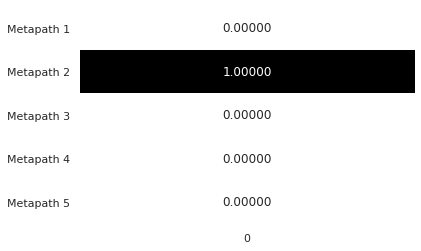

In [35]:
ax = sns.heatmap(firstBatchPathAttention.sum(dim = 1).reshape(5, 1),
                 cmap = cmap, 
                 annot=True, 
                 fmt = ".5f", 
                 yticklabels = y_labels,
                 cbar = False
                )

## input of path attention ( after node attention)

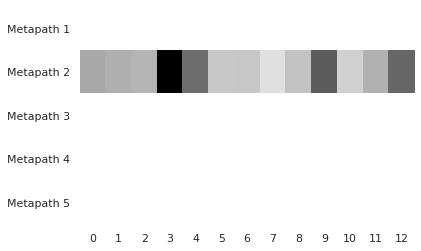

In [36]:
node_z_shape = attention['node_Z'].shape
node_z = attention['node_Z'].reshape(node_z_shape[0]*node_z_shape[1]*node_z_shape[2], node_z_shape[3]) # (B*L*, E)
ax = sns.heatmap(-node_z.sum(dim = -1).reshape((5, -1)), cmap=cmap, annot=False, fmt = ".2f",
                 yticklabels = y_labels,
                 cbar = False
                ) #(B*L, 1)
fig = ax.get_figure()
fig.savefig("pathattention.png", dpi = 400, bbox_inches='tight')

#  Node attention

In [37]:
len(attention['node']), attention['node'][0].shape, attention['node'][1].shape

(5, torch.Size([13, 3, 384]), torch.Size([13, 7, 384]))

In [38]:
attention['node'][0].mean(dim = -1).shape

torch.Size([13, 3])

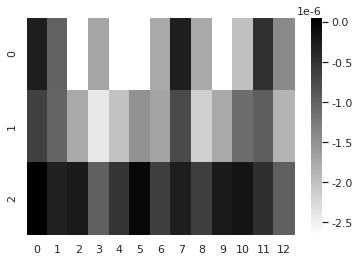

In [39]:
ax = sns.heatmap(attention['node'][0].mean(dim = -1).T, cmap=cmap, annot=False, fmt = ".0f")

In [40]:
(pad_path_matrix(node_attentions) * firstBatchPathAttention.reshape(-1, 1)).T.shape

NameError: name 'node_attentions' is not defined

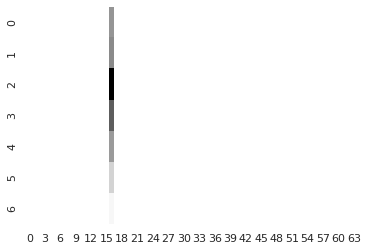

In [41]:
node_attentions = []
for i, path in enumerate(attention['node']):
#     if i == 0: continue
    node_attentions.append(path.mean(-1))

ax = sns.heatmap((pad_path_matrix(node_attentions) * firstBatchPathAttention.reshape(-1, 1)).T,
                 cmap='gist_gray',
                 cbar = False)

In [42]:
firstBatchPathAttention[1].reshape(path_per_meta, 1)

tensor([[6.9116e-06],
        [4.4071e-06],
        [3.0407e-06],
        [9.9724e-01],
        [4.7481e-04],
        [7.4775e-07],
        [8.0389e-07],
        [1.3350e-07],
        [1.1151e-06],
        [1.5243e-03],
        [4.1762e-07],
        [3.7007e-06],
        [7.3664e-04]])

In [43]:
from copy import deepcopy 

In [44]:
pathAtt

NameError: name 'pathAtt' is not defined

In [45]:
torch.where(node_attentions[1].reshape((-1,path_per_meta))* pathAtt.T < -1e-4, to_draw/10000 , to_draw)

NameError: name 'pathAtt' is not defined

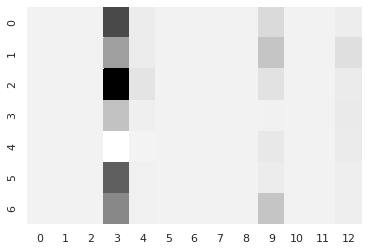

In [55]:
pathAtt = deepcopy(firstBatchPathAttention[1].reshape(path_per_meta, 1))
to_draw = node_attentions[1].reshape((-1,path_per_meta))* pathAtt.T
pathAtt[3] = pathAtt[3] /100
ax = sns.heatmap(node_attentions[1].reshape((-1,path_per_meta))* pathAtt.T,
                 cmap='gist_gray',
                 cbar = False
                )
fig = ax.get_figure()
fig.savefig("interaction.png", dpi = 400, bbox_inches='tight')

In [56]:
node_attentions[1].reshape((-1,path_per_meta)).sum()

tensor(-0.0197)

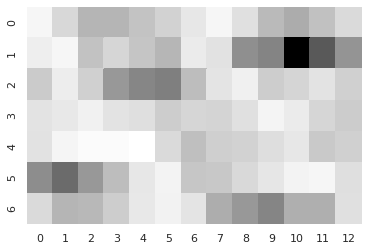

In [57]:
ax = sns.heatmap(node_attentions[1].reshape((-1,path_per_meta)),# * firstBatchPathAttention[1].reshape(path_per_meta, 1).T,
                 cmap='gist_gray',
                 cbar = False
                )
fig = ax.get_figure()
fig.savefig("interaction_with_path_attention.png", dpi = 400, bbox_inches='tight')